In [1]:
from nn_grad import Node
from nn_loss import MinsqrLoss, LogLoss
from nn_optimizer import AdamOptim, StochasticOptim
from nn_layer import *
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

In [3]:
data = np.c_[housing.data, housing.target]
columns = np.append(housing.feature_names, ["target"])
dataframe = pd.DataFrame(data, columns=columns)

In [4]:
dataframe.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'target'],
      dtype='object')

In [5]:

dt = dataframe.to_numpy()

In [6]:
x_ = dt[:, 0:8]
y_ = dt[:, 8]

y_ = y_.reshape(len(y_), 1)

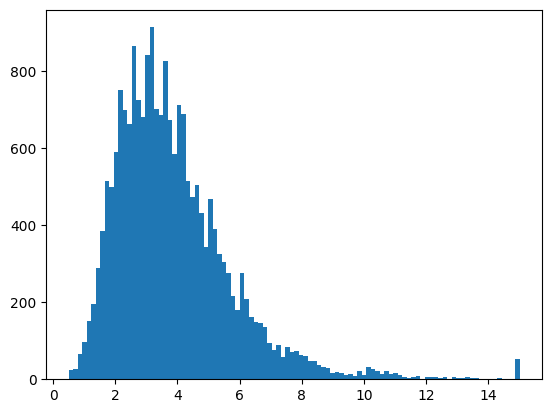

In [7]:

plt.hist(x_[:, 0], bins=100)
plt.show()

In [8]:
dataframe = dataframe.assign(IncomeClass=pd.Series(np.zeros(len(dataframe))).values)

dataframe.loc[dataframe.MedInc < 2, 'IncomeClass'] = 0

dataframe.loc[ (dataframe.MedInc >= 2) &  (dataframe.MedInc < 4), 'IncomeClass'] = 1

dataframe.loc[ (dataframe.MedInc >= 4) &  (dataframe.MedInc < 6), 'IncomeClass'] = 2

dataframe.loc[ (dataframe.MedInc >= 6), 'IncomeClass'] = 3


(array([ 960.,    0.,    0., 2517.,    0.,    0., 1068.,    0.,    0.,
         456.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

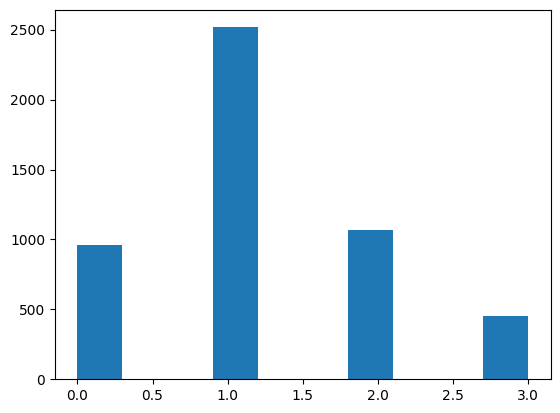

In [9]:
plt.hist(dataframe.loc[0:5000, 'IncomeClass'])

In [11]:
dt = dataframe.loc[0:5000].to_numpy()
x_ = dt[:, 1:9]
y_ = dt[:, 9]

y_ = np.array([[1, 0, 0, 0] if y == 0 else
               [0, 1, 0, 0] if y == 1 else
               [0, 0, 1, 0] if y == 2 else
               [0, 0, 0, 1]
               for y in y_])

In [13]:

x_train, x_test, y_train,y_test = train_test_split(x_, y_, test_size=0.25, shuffle=True)

In [60]:

def train(net, x_train, y_train, x_test, y_test, lr):
    np.seterr(all='ignore')

    indxs = list(range(0, x_train.shape[0]))

    epochs = 10 ** 5 * 3

    optim = AdamOptim(net, lr=lr)

    loss = LogLoss()


    acc_scores = []

    f1_scores = []

    loss_scores = []


    arg_train = np.argmax(y_train, 1)

    arg_test = np.argmax(y_test, 1)


    for epoch in range(0, epochs + 1):

        y_train_pred = net.forward(Node(x_train))

        loss_ = loss.backward(y_train_pred, y_train)

        optim.descend()


        if epoch % 10 ** 2 == 0:

            train_loss = loss_.val / y_train.shape[0] / y_train.shape[1]


            print(f'epoch: {epoch} loss value: {train_loss}')


            if epoch % 10 ** 3 == 0:

                y_test_pred = net.forward(Node(x_test))


                test_loss = loss.count_loss(

                    y_test_pred, y_test).val / y_train.shape[0] / y_train.shape[1]


                train_res = np.argmax(y_train_pred.val, axis=1)

                test_res = np.argmax(y_test_pred.val, axis=1)


                train_acc = accuracy_score(arg_train, train_res)

                test_acc = accuracy_score(arg_test, test_res)


                train_f1 = f1_score(arg_train, train_res, average='macro')

                test_f1 = f1_score(arg_test, test_res, average='macro')


                acc_scores.append([train_acc, test_acc, epoch])

                f1_scores.append([train_f1, test_f1, epoch])

                loss_scores.append([train_loss, test_loss, epoch])


            if train_loss < 10 ** -2:
                break

    return (loss_scores, f1_scores, acc_scores)

In [61]:
def display(loss_scores, f1_scores, acc_scores):
    loss_scores = np.array(loss_scores)
    f1_scores = np.array(f1_scores)
    acc_scores = np.array(acc_scores)

    figure, axis = plt.subplots(1, 3)

    figure.set_figwidth(20)
    figure.set_figheight(10)

    axis[0].set_xlabel('epoch')
    axis[0].set_ylabel('loss')
    axis[0].set_title('Loss score')
    axis[0].plot(loss_scores[:, 2], loss_scores[:, 0],
                 marker='o', label='train')
    axis[0].plot(loss_scores[:, 2], loss_scores[:, 1],
                 marker='o', label='test')
    axis[0].legend()

    axis[1].set_xlabel('epoch')
    axis[1].set_ylabel('accuracy')
    axis[1].set_title('Accuracy score')
    axis[1].plot(acc_scores[:, 2], acc_scores[:, 0], marker='o', label='train')
    axis[1].plot(acc_scores[:, 2], acc_scores[:, 1], marker='o', label='test')
    axis[1].legend()

    axis[2].set_xlabel('epoch')
    axis[2].set_ylabel('f1')
    axis[2].set_title('F1 score')
    axis[2].plot(f1_scores[:, 2], f1_scores[:, 0], marker='o', label='train')
    axis[2].plot(f1_scores[:, 2], f1_scores[:, 1], marker='o', label='test')
    axis[2].legend()
    plt.show()

In [62]:
from nn_layer import nnLayer

from nn_loss import *


class nnImplDot:

    def __init__(self, in_dim, out_dim):

        self.with_bias = True
        self.layers: np.ndarray[nnLayer] = [
            LinearLayer(in_dim, 20, with_bias=self.with_bias, kernel=Node.dot),
            ReluLayer(),
            SigmoidLayer(),
            LinearLayer(20, out_dim, with_bias=self.with_bias, kernel=Node.dot),
            SoftargmaxLayer()]

    def forward(self, x_: Node) -> Node:
        for layer in self.layers:
            x_ = layer.forward(x_)
        return x_

In [63]:
net1 = nnImplDot(x_train.shape[1], y_train.shape[1])
stats1 = train(net1, x_train, y_train, x_test, y_test, lr=10**-5*5)

epoch: 0 loss value: 0.4428594748312352
epoch: 100 loss value: 0.4071009158367596
epoch: 200 loss value: 0.385027250239435
epoch: 300 loss value: 0.3669187540256478
epoch: 400 loss value: 0.34901185656168643
epoch: 500 loss value: 0.33249028330739927
epoch: 600 loss value: 0.3214811956673404
epoch: 700 loss value: 0.31450820114061206
epoch: 800 loss value: 0.3098385389709958
epoch: 900 loss value: 0.3064408310430925
epoch: 1000 loss value: 0.304147578360215
epoch: 1100 loss value: 0.3027833584088689
epoch: 1200 loss value: 0.3021249415440958
epoch: 1300 loss value: 0.3018968141375983
epoch: 1400 loss value: 0.3018329384027261
epoch: 1500 loss value: 0.3017952179178136
epoch: 1600 loss value: 0.30175428808285665
epoch: 1700 loss value: 0.30171294430508855
epoch: 1800 loss value: 0.3016824668226217
epoch: 1900 loss value: 0.30165551693082465
epoch: 2000 loss value: 0.30162838107798523
epoch: 2100 loss value: 0.301600685851882
epoch: 2200 loss value: 0.3015726418378946
epoch: 2300 loss va

KeyboardInterrupt: 

In [ ]:
display(*stats1)

In [ ]:
from nn_layer import nnLayer

from nn_loss import *


class nnImplGauss:

    def __init__(self, in_dim, out_dim):
        self.with_bias = True
        self.layers: np.ndarray[nnLayer] = [
            LinearLayer(in_dim, 16, with_bias=self.with_bias, kernel=Node.gauss),
            ReluLayer(),
            LinearLayer(16, 12, with_bias=self.with_bias, kernel=Node.gauss),
            LinearLayer(12, out_dim, with_bias=self.with_bias, kernel=Node.gauss),
            SoftargmaxLayer()]

    def forward(self, x_: Node) -> Node:
        for layer in self.layers:
            x_ = layer.forward(x_)
        return x_

In [ ]:
net2 = nnImplGauss(x_train.shape[1], y_train.shape[1])
stats2 = train(net2, x_train, y_train, x_test, y_test, lr=10**-5*5)

In [ ]:
display(*stats2)

In [ ]:
from nn_layer import nnLayer

from nn_loss import *


class nnImplMixed:

    def __init__(self, in_dim, out_dim):

        self.with_bias = True
        self.layers: np.ndarray[nnLayer] = [
            LinearLayer(in_dim, 10, with_bias=self.with_bias, kernel=Node.dot),
            ReluLayer(),
            LinearLayer(10, 15, with_bias=self.with_bias, kernel=Node.gauss),
            ReluLayer(),
            LinearLayer(15, out_dim, with_bias=self.with_bias, kernel=Node.dot),
            SoftargmaxLayer()]

    def forward(self, x_: Node) -> Node:
        for layer in self.layers:
            x_ = layer.forward(x_)
        return x_


In [ ]:
net3 = nnImplMixed(x_train.shape[1], y_train.shape[1])
stats3 = train(net3, x_train, y_train, x_test, y_test, lr=10**-5*5)

In [ ]:
display(*stats3)